In [36]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [37]:
import pandas as pd
import numpy as np
import os
import cv2
import csv
import random
import math
from shapely.geometry import Polygon
from itertools import compress
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D,Input,UpSampling2D,BatchNormalization,Concatenate,Input,Dense,Flatten,Activation
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# loading trained detection model

In [38]:
# class feature_merging_branch(tf.keras.layers.Layer):
#     def __init__(self,name='f_m_b',**kwargs):
#         super().__init__(name)
#     def build(self,input_shape1):
#         #print(input_shape1)
# #         input_shape1=input_list[0]
# #         input_shape2=input_list[1]
#         self.upsample=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')
#         self.concat=Concatenate(axis=3)
#         self.conv1=Conv2D(input_shape1[-1]//2,1,padding='same',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12))
#         self.conv2=Conv2D(input_shape1[-1]//2,3,padding='same',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12))
#         self.bn1=BatchNormalization()
#         self.bn2=BatchNormalization()
#         self.act1=Activation('relu')
#         self.act2=Activation('relu')
#     def call(self,input_1,input_2):
# #         input_1=input_list[0]
# #         input_2=input_list[1]
#         up1=self.upsample(input_1)
#         concat1=self.concat([input_2,up1])
#         conv1=self.conv1(concat1)
#         bn1=self.bn1(conv1)
#         act1=self.act1(bn1)
#         conv2=self.conv2(act1)
#         bn2=self.bn2(conv2)
#         act2=self.act2(bn2)
#         #onv2=self.bn(conv2)
#         return act2
    
    
class feature_merging_branch(tf.keras.layers.Layer):
    def __init__(self,name='f_m_b',kernel=128,**kwargs):
        super().__init__(name)
        self.l_name=name
        self.kernel=kernel
    def build(self,input_shape1):
        print(input_shape1,'input shape1')
        self.conv1=Conv2D(self.kernel,1,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.conv2=Conv2D(self.kernel,3,padding='same',kernel_regularizer=tf.keras.regularizers.l2(1e-5))
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()

    def call(self,input_1):

        conv1=self.conv1(input_1)
        bn1=self.bn1(conv1)
        act1=Activation('relu')(bn1)
        conv2=self.conv2(act1)
        bn2=self.bn2(conv2)
        act2=Activation('relu')(bn2)
        #onv2=self.bn(conv2)
        return act2
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'name': self.l_name,
            'kernel': self.kernel,
            })
        return config  
    
# class feature_merging_branch(tf.keras.layers.Layer):
#     def __init__(self,name='f_m_b',**kwargs):
#         super().__init__(name)
#     def build(self,input_shape1):
#         #print(input_shape1)
# #         input_shape1=input_list[0]
# #         input_shape2=input_list[1]
#         self.upsample=UpSampling2D(2,interpolation='bilinear',data_format='channels_last')
#         self.concat=Concatenate(axis=3)
#         self.conv1=Conv2D(input_shape1[-1]//2,1,padding='same',activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12))
#         self.conv2=Conv2D(input_shape1[-1]//2,3,padding='same',activation='relu',kernel_initializer=tf.keras.initializers.GlorotNormal(seed=12))
#         self.bn=BatchNormalization()
#     def call(self,input_1,input_2):
# #         input_1=input_list[0]
# #         input_2=input_list[1]
#         up1=self.upsample(input_1)
#         concat1=self.concat([input_2,up1])
#         conv1=self.conv1(concat1)
#         conv2=self.conv2(conv1)
#         conv2=self.bn(conv2)
#         return conv2    

In [39]:
# computing dice loss
def dice_loss(y_true_class,y_pred_class,training_mask):
    # we  are taking intersecting pixels ignoring pixels in training masks
    intersection=tf.reduce_sum(y_true_class*y_pred_class*training_mask)
    # calculating sum of total pixels where pixel is text
    union=tf.reduce_sum(y_true_class*training_mask)+tf.reduce_sum(y_pred_class*training_mask)
    eps=10**-7
    # calculating dice loss
    dice_loss_=1-(2*(intersection/(union+eps)))
    return dice_loss_

In [40]:
class detection_loss(tf.keras.losses.Loss):
    def __init__(self,reduction=tf.keras.losses.Reduction.AUTO, name=None):
        super().__init__(reduction=reduction, name=name)
    def call(self,y_true,y_pred):
        y_true_score=y_true[:,:,:,0]
        y_pred_score=y_pred[:,:,:,0]
        y_true_geo=y_true[:,:,:,1:6]
        y_pred_geo=y_pred[:,:,:,1:6]
        training_mask=y_true[:,:,:,6]
        loss_for_score=dice_loss(y_true_score,y_pred_score,training_mask)
        loss_for_score*=0.01
        # print(tf.math.equal(tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)[0],45))
        d_t_gt, d_r_gt, d_b_gt, d_l_gt, angle_gt = tf.split(value=y_true_geo, num_or_size_splits=5, axis=3)
        d_t_pd, d_r_pd, d_b_pd, d_l_pd, angle_pd = tf.split(value=y_pred_geo, num_or_size_splits=5, axis=3)
        # calculating area regarding each pixels with the help of hight and width
        area_pred= (d_t_pd+d_b_pd)*(d_r_pd+d_l_pd)
        # calculating area of original text area
        area_real= (d_t_gt+d_b_gt)*(d_r_gt+d_l_gt)
        # calculating intersected rectangle width
        width_intersected_rectangle=tf.minimum(d_r_gt,d_r_pd) + tf.minimum(d_l_gt,d_l_pd)
        # calculating intersected rectangle height
        height_intersected_rectangle=tf.minimum(d_t_gt,d_t_pd) + tf.minimum(d_b_gt,d_b_pd)
        # intersected area by multiplying intersected height snd intersected width
        intersected_area=width_intersected_rectangle*height_intersected_rectangle
        # total area which belongs to both actual text and the predicted text
        union_area=area_pred+area_real-intersected_area
        # calculating iou
        loss_iou=-tf.math.log((intersected_area+1)/(union_area+1))
        # calculating angle loss
        angle_loss=1-tf.cos(angle_pd-angle_gt)
        final_loss= (loss_iou)+(20*angle_loss)
        #print(final_loss.shape)
        #final_loss=tf.squeeze(final_loss,axis=3)
        return 100*(tf.reduce_mean(final_loss*y_true_score*training_mask)+(loss_for_score))

In [41]:
detectors=tf.keras.models.load_model('detector_model.h5',custom_objects={'feature_merging_branch':feature_merging_branch,'detection_loss':detection_loss})

(None, 32, 32, 768) input shape1
(None, 64, 64, 256) input shape1
(None, 128, 128, 128) input shape1


In [42]:
img=cv2.imread('data/ch4_training_images/img_29.jpg',cv2.IMREAD_UNCHANGED)
img = cv2.resize(img, dsize=(512, 512),interpolation = cv2.INTER_AREA)
# img1 = cv2.resize(img, dsize=(512, 512))
print(img.shape)
pred=detectors.predict(img[np.newaxis,:,:,:])

(512, 512, 3)


### showing real image on which we are detecting image

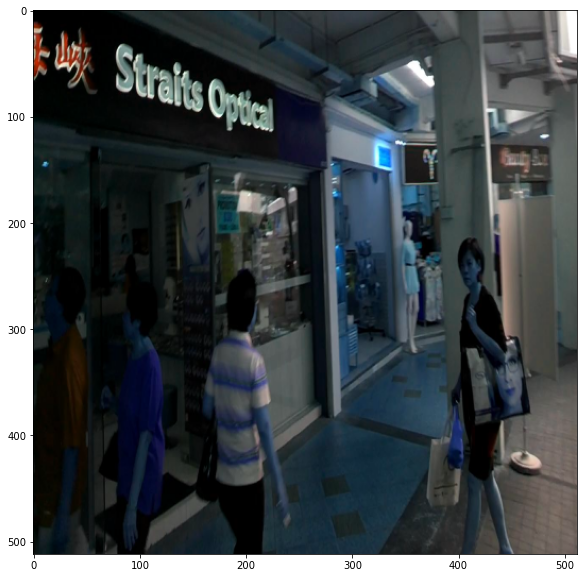

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

### now see it's predicted score map

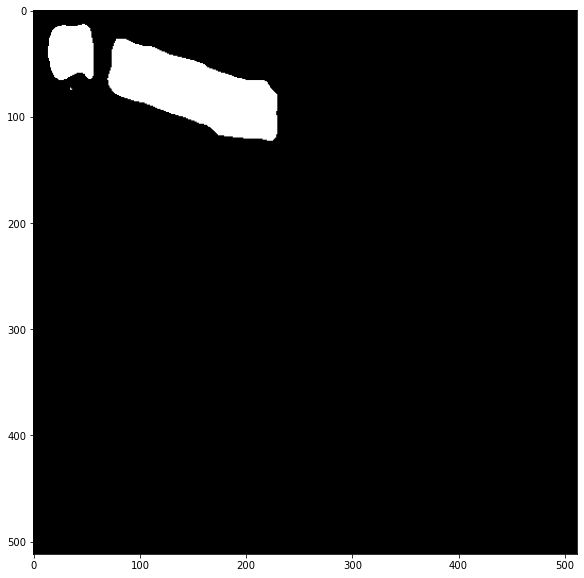

In [44]:
score_map=np.where((pred[0][:,:,0]>0.5),1,0)
plt.figure(figsize=(10,10))
plt.imshow(score_map,cmap="gray")
plt.show()

In [10]:
pred.shape

(1, 512, 512, 6)

### like this we can plot for geo maps also, let's see for distance from top map

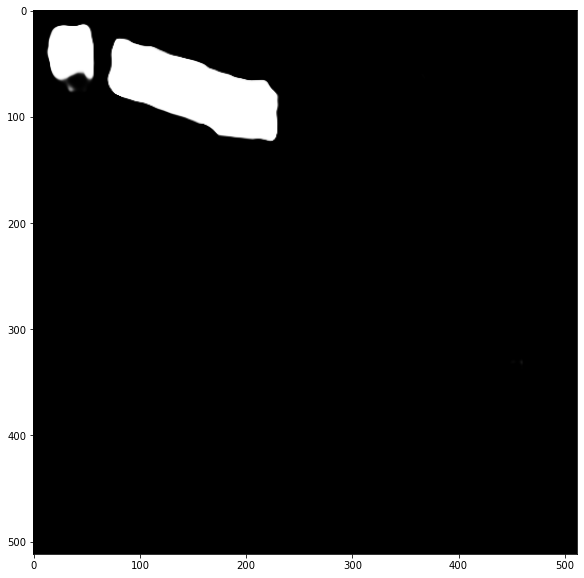

In [24]:
geo_map_top=pred[0][:,:,0]
plt.figure(figsize=(10,10))
plt.imshow(geo_map_top,cmap="gray")
plt.show()

# loading trained recognizer model

In [8]:
def ctc_loss(y_true,y_pred):
  
  #https://stackoverflow.com/questions/64321779/how-to-use-tf-ctc-loss-with-variable-length-features-and-labels
  label_length = tf.math.count_nonzero(y_true, axis=-1, keepdims=True)
  return tf.keras.backend.ctc_batch_cost(y_true,y_pred,np.ones((32,1),'int32')*64,label_length)

In [9]:
recognizer=tf.keras.models.load_model('best_recognizer.h5',custom_objects={'ctc_loss':ctc_loss})

###  let's see how it's predicting the image which we are trying is this

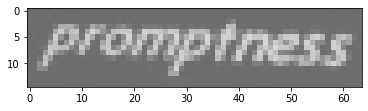

In [27]:
img=cv2.imread('data/word_images/54478_promptness.png')
plt.imshow(img)
plt.show()

In [28]:
#img = cv2.resize(img, dsize=(512, 512))
pred=recognizer.predict(img[np.newaxis,:,:,:])

In [10]:
# for decoding predicted output from recognizer we are loading our saved tokenizer during training
import pickle
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [30]:
# using tensorflow ctc_decode for decoding predicted output
pred_arr=tf.keras.backend.ctc_decode(pred,np.ones((1),'int8')*64,)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [31]:
txt=''
for i in pred_arr[0][0].numpy()[0]:
    txt=txt+tokenizer.index_word[i]
print(txt)    

promptness


### you can see it's giving output 'promptness', which is in above image

# Making pipeline

### prducing bounding boxes with respect to each pixel which is detected as 1(text area)

In [11]:
#
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/yu20103983/FOTS
# https://github.com/Masao-Taketani/FOTS_OCR
def restore_rectangle_rbox(origin, geometry):
    ''' Resotre rectangle tbox'''
    #print(geometry.shape)
    d = geometry[:, :4]
    #print(d.shape)
    angle = geometry[:, 4]
    # for angle > 0
    #print(angle)
    # print((angle>=0).shape)
    #print(origin)
    origin_0 = origin[angle >= 0]
    #print(origin_0.shape)
    d_0 = d[angle >= 0]
    #print(d_0.shape)
    #print(d_0)
    angle_0 = angle[angle >= 0]
    #print(angle_0.shape)
    #print(-d_0[:, 0] - d_0[:, 2])
    if origin_0.shape[0] > 0:
        p = np.array([np.zeros(d_0.shape[0]), -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], -d_0[:, 0] - d_0[:, 2],
                      d_0[:, 1] + d_0[:, 3], np.zeros(d_0.shape[0]),
                      np.zeros(d_0.shape[0]), np.zeros(d_0.shape[0]),
                      d_0[:, 3], -d_0[:, 2]])
        #print(p.shape)
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2
#         print(p.shape)

        rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        # print(p_rotate_x)
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_0 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
        #print(origin_0)
        #print(new_p_0)
    else:
        new_p_0 = np.zeros((0, 4, 2))
    # for angle < 0
    origin_1 = origin[angle < 0]
    d_1 = d[angle < 0]
    angle_1 = angle[angle < 0]
    if origin_1.shape[0] > 0:
        p = np.array([-d_1[:, 1] - d_1[:, 3], -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), -d_1[:, 0] - d_1[:, 2],
                      np.zeros(d_1.shape[0]), np.zeros(d_1.shape[0]),
                      -d_1[:, 1] - d_1[:, 3], np.zeros(d_1.shape[0]),
                      -d_1[:, 1], -d_1[:, 2]])
        p = p.transpose((1, 0)).reshape((-1, 5, 2))  # N*5*2

        rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
        rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  # N*5*2

        rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
        rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

        p_rotate_x = np.sum(rotate_matrix_x * p, axis=2)[:, :, np.newaxis]  # N*5*1
        p_rotate_y = np.sum(rotate_matrix_y * p, axis=2)[:, :, np.newaxis]  # N*5*1

        p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  # N*5*2

        p3_in_origin = origin_1 - p_rotate[:, 4, :]
        new_p0 = p_rotate[:, 0, :] + p3_in_origin  # N*2
        new_p1 = p_rotate[:, 1, :] + p3_in_origin
        new_p2 = p_rotate[:, 2, :] + p3_in_origin
        new_p3 = p_rotate[:, 3, :] + p3_in_origin

        new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                  new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  # N*4*2
    else:
        new_p_1 = np.zeros((0, 4, 2))
    return np.concatenate([new_p_0, new_p_1])

In [12]:
def restore_rectangle(origin, geometry):
    return restore_rectangle_rbox(origin, geometry)

def getRotateRect(box):
    rect = cv2.minAreaRect(box)

    angle=rect[2]  # angle = [-90, 0)
    if angle < -45:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        angle += 90
        size = (rect[1][1],rect[1][0])
    else:
        rect = (rect[0], (rect[1][0], rect[1][1]), rect[2])
        size=rect[1]

    box_ = cv2.boxPoints(rect)
    return np.concatenate([rect[0], size]), angle, box_

In [13]:
def sort_rectangle(poly):
    # sort the four coordinates of the polygon, points in poly should be sorted clockwise
    # First find the lowest point
    p_lowest = np.argmax(poly[:, 1])
    if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
        # 底边平行于X轴, 那么p0为左上角 - if the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        p0_index = np.argmin(np.sum(poly, axis=1))
        p1_index = (p0_index + 1) % 4
        p2_index = (p0_index + 2) % 4
        p3_index = (p0_index + 3) % 4
        return poly[[p0_index, p1_index, p2_index, p3_index]], 0.
    else:
        # 找到最低点右边的点 - find the point that sits right to the lowest point
        p_lowest_right = (p_lowest - 1) % 4
        p_lowest_left = (p_lowest + 1) % 4
        angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))
        # assert angle > 0
        if angle <= 0:
            print(angle, poly[p_lowest], poly[p_lowest_right])
        if angle/np.pi * 180 > 45:
            # 这个点为p2 - this point is p2
            p2_index = p_lowest
            p1_index = (p2_index - 1) % 4
            p0_index = (p2_index - 2) % 4
            p3_index = (p2_index + 1) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)
        else:
            # 这个点为p3 - this point is p3
            p3_index = p_lowest
            p0_index = (p3_index + 1) % 4
            p1_index = (p3_index + 2) % 4
            p2_index = (p3_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], angle

In [14]:
def generate_roiRotatePara(box, angle, expand_w = 60):
    '''Generate all ROI Parameterts'''
    #print(box)
    p0_rect, p1_rect, p2_rect, p3_rect = box
    cxy = (p0_rect + p2_rect) / 2.
    size = np.array([np.linalg.norm(p0_rect - p1_rect), np.linalg.norm(p0_rect - p3_rect)])
    rrect = np.concatenate([cxy, size])

    box=np.array(box)

    points=np.array(box, dtype=np.int32)
    xmin=np.min(points[:,0])
    xmax=np.max(points[:,0])
    ymin=np.min(points[:,1])
    ymax=np.max(points[:,1])
    bbox = np.array([xmin, ymin, xmax, ymax])
    if np.any(bbox < -expand_w):
        return None
    
    rrect[:2] -= bbox[:2]
    rrect[:2] -= rrect[2:] / 2
    rrect[2:] += rrect[:2]

    bbox[2:] -= bbox[:2]

    rrect[::2] = np.clip(rrect[::2], 0, bbox[2])
    rrect[1::2] = np.clip(rrect[1::2], 0, bbox[3])
    rrect[2:] -= rrect[:2]
    
    return bbox.astype(np.int32), rrect.astype(np.int32), - angle

def restore_roiRotatePara(box):
    rectange, rotate_angle = sort_rectangle(box)
    return generate_roiRotatePara(rectange, rotate_angle)

### this block of code is for selecting those bounding boxes which have intersected more

In [15]:
#These Are Function that will be used while converting geo_maps to score_maps
#Codes Taken from
# https://github.com/Pay20Y/FOTS_TF
# https://github.com/yu20103983/FOTS
# https://github.com/Masao-Taketani/FOTS_OCR

import time

def sort_poly(p):
  min_axis = np.argmin(np.sum(p, axis=1))
  p = p[[min_axis, (min_axis+1)%4, (min_axis+2)%4, (min_axis+3)%4]]
  if abs(p[0, 0] - p[1, 0]) > abs(p[0, 1] - p[1, 1]):
    return p
  else:
    return p[[0, 3, 2, 1]]
def intersection(g, p):
    g = Polygon(g[:8].reshape((4, 2)))
    p = Polygon(p[:8].reshape((4, 2)))
    if not g.is_valid or not p.is_valid:
        return 0
    inter = Polygon(g).intersection(Polygon(p)).area
    union = g.area + p.area - inter
    if union == 0:
        return 0
    else:
        return inter/union


def weighted_merge(g, p):
    g[:8] = (g[8] * g[:8] + p[8] * p[:8])/(g[8] + p[8])
    g[8] = (g[8] + p[8])
    return g


def standard_nms(S, thres):
    order = np.argsort(S[:, 8])[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        ovr = np.array([intersection(S[i], S[t]) for t in order[1:]])

        inds = np.where(ovr <= thres)[0]
        order = order[inds+1]

    return S[keep]


def nms_locality(polys, thres=0.3):
    '''
    :param polys: a N*9 numpy array. first 8 coordinates, then prob
    :return: boxes after nms
    '''
    S = []
    p = None
    for g in polys:
        if p is not None and intersection(g, p) > thres:
            p = weighted_merge(g, p)
        else:
            if p is not None:
                S.append(p)
            p = g
    if p is not None:
        S.append(p)

    if len(S) == 0:
        return np.array([])
    return standard_nms(np.array(S), thres)

# pipeline

In [16]:
#This is final Inference function used for complete FOTS pipeline
def inferencePipeline(img):
    '''This function is main complete pipeline of our Model'''
    start_time=time.time()

    #1.Text Detection
    img=cv2.resize(img,dsize=(512,512),interpolation = cv2.INTER_AREA)
    ii=detectors.predict(np.expand_dims(img,axis=0))
    score_map=ii[0][:,:,0]
    
    geo_map=ii[0][:,:,1:]
    
    #print(score_map.shape)
    #print(geo_map.shape)
    #print(geo_map)
    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map

    #print(geo_map.shape)
    #print(geo_map)
    
    #2.ROI Rotate  
    score_map_thresh=0.5
    box_thresh=0.3
    nms_thres=0.1
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)

    # print(xy_text)
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    # print(xy_text)
    
    # print(xy_text[:, ::-1])
    # restore
    text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
    #print('text_box_restored',text_box_restored.shape)
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    # print(boxes)
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # boxes = cv2.dnn.NMSBoxes(boxes, score_map, 0.3, (0.1))
    print(boxes.shape)
    #print(boxes)
    
    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   
    #print(res)
    box_index = []
    brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            # print(rbox)
            para = restore_roiRotatePara(rbox)
            #break
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[]   
    
    # print(rotateParas)

    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 

    if len(rotateParas) > 0:
          for num in range(len(rotateParas)):
                text=""
                out=rotateParas[num][0]
                crop=rotateParas[num][1]
                points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
                angle=rotateParas[num][2] 
                #print(out)
#                 img1=tf.image.crop_to_bounding_box(img,out[1]-(int(out[1]*(5/100))),out[0]-(int(out[0]*(5/100))),out[3]+(int(out[3]*(55/100))),out[2]+(int(out[2]*(55/100))))
                # print(out)
                img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
                #print(img1.shape)
#                 plt.imshow(img1)
#                 plt.show()
                img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
                
                #print(crop)
                #print(crop[0])
                img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
#                 plt.imshow(img2)
#                 plt.show()
                img2=cv2.resize(img2,(64,15))
                img2=cv2.detailEnhance(img2)
                ii=recognizer.predict(np.expand_dims(img2,axis=0))
                arr=tf.keras.backend.ctc_decode(ii,np.ones((1),'int8')*64,)
                for val in arr[0][0].numpy()[0]:
                      if val==-1:
                        break
                      else:
                        text+=tokenizer.index_word[val]
                txt.append(text)
                pts.append(points)
                #break

    # 4. Labeling detected and Recognized Text in Image

    for i in range(len(txt)):
        #print(pts[i])
#         pts[i][0][0]=pts[i][0][0]-(pts[i][0][0]*(10/100))
#         pts[i][0][1]=pts[i][0][1]-(pts[i][0][1]*(5/100))
        
#         pts[i][1][0]=pts[i][1][0]+(pts[i][1][0]*(10/100))
#         pts[i][1][1]=pts[i][1][1]-(pts[i][1][1]*(5/100))
        
#         pts[i][2][0]=pts[i][2][0]+(pts[i][2][0]*(10/100))
#         pts[i][2][1]=pts[i][2][1]+(pts[i][2][1]*(5/100))
        
#         pts[i][3][0]=pts[i][3][0]-(pts[i][3][0]*(10/100))
#         pts[i][3][1]=pts[i][3][1]+(pts[i][3][1]*(5/100))
        
        cv2.polylines(img,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
        cv2.putText(img,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
        print(txt[i])
    end_time=time.time()
    print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds")  
    return img   

(13, 9)
ananoufsd
2
cinol
kuniy
jeytean
boarl
neos
se
oiofed

Time Taken By Pipeline=2.6830642223358154 seconds


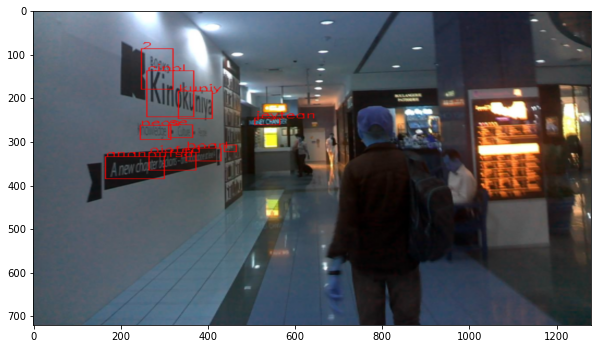

In [35]:
img=cv2.imread('data/ch4_test_images/img_1327.jpg',cv2.IMREAD_UNCHANGED)
#print(img.shape)
im=inferencePipeline(img)
im=cv2.resize(im,dsize=(1280,720))
plt.figure(figsize=(10,10))
plt.imshow(im)

# converting model to tflite model

In [12]:
converter=tf.lite.TFLiteConverter.from_keras_model(detectors)

In [13]:
tflite_detector=converter.convert()

In [14]:
open('detection.tflite','wb').write(tflite_detector)

91158848

In [15]:
converter=tf.lite.TFLiteConverter.from_keras_model(recognizer)

In [16]:
tflite_recognize=converter.convert()

In [17]:
open('recognizer.tflite','wb').write(tflite_recognize)

1233012

In [46]:
detectors = tf.lite.Interpreter(model_path="detection.tflite")
detectors.allocate_tensors()

In [47]:
input_details_detector = detectors.get_input_details()
output_details_detector = detectors.get_output_details()

In [48]:
input_details_detector

[{'name': 'input_1',
  'index': 0,
  'shape': array([  1, 512, 512,   3]),
  'shape_signature': array([  1, 512, 512,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [55]:
recognizer = tf.lite.Interpreter(model_path="recognizer.tflite")
recognizer.allocate_tensors()

In [56]:
input_details_recognizer = recognizer.get_input_details()
output_details_recognizer = recognizer.get_output_details()

In [62]:
#This is final Inference function used for complete FOTS pipeline
def inferencePipeline_lite(img):
    '''This function is main complete pipeline of our Model'''
    start_time=time.time()

    #1.Text Detection
    img=cv2.resize(img,dsize=(512,512),interpolation = cv2.INTER_AREA)
    detectors.set_tensor(input_details_detector[0]['index'], np.expand_dims(img,axis=0).astype(np.float32))
    detectors.invoke()
    ii = detectors.get_tensor(output_details_detector[0]['index'])
    score_map=ii[0][:,:,0]
    
    geo_map=ii[0][:,:,1:]
    
    
    for ind in [0,1,2,3,4]:
        geo_map[:,:,ind]*=score_map

    
    #2.ROI Rotate  
    score_map_thresh=0.5
    box_thresh=0.3
    nms_thres=0.1
    if len(score_map.shape) == 4:
        score_map = score_map[0, :, :, 0]
        geo_map = geo_map[0, :, :, :]
    # filter the score map
    xy_text = np.argwhere(score_map > score_map_thresh)

    
    # sort the text boxes via the y axis
    xy_text = xy_text[np.argsort(xy_text[:, 0])]
    
    # restore
    text_box_restored = restore_rectangle(xy_text[:, ::-1], geo_map[xy_text[:, 0], xy_text[:, 1], :]) # N*4*2
    #print('text_box_restored',text_box_restored.shape)
    boxes = np.zeros((text_box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = text_box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]
    # print(boxes)
    boxes = nms_locality(boxes.astype(np.float64), nms_thres)
    # boxes = cv2.dnn.NMSBoxes(boxes, score_map, 0.3, (0.1))
    print(boxes.shape)
    #print(boxes)
    
    res = []
    result = []
    if len(boxes)>0:
        for box in boxes:
            box_ =  box[:8].reshape((4, 2))
            if np.linalg.norm(box_[0] - box_[1]) < 8 or np.linalg.norm(box_[3]-box_[0]) < 8:
                continue
            result.append(box_)
    res.append(np.array(result, np.float32))   
    #print(res)
    box_index = []
    brotateParas = []
    filter_bsharedFeatures = []
    for i in range(len(res)):
        rotateParas = []
        rboxes=res[i]
        txt=[]
        for j, rbox in enumerate(rboxes):
            # print(rbox)
            para = restore_roiRotatePara(rbox)
            #break
            if para and min(para[1][2:]) > 8:
                rotateParas.append(para)
                box_index.append((i, j))
        pts=[]   
    
    # print(rotateParas)

    #3. Text Recognition (From boxes given by Text Detection+ROI Rotate) 

    if len(rotateParas) > 0:
          for num in range(len(rotateParas)):
                text=""
                out=rotateParas[num][0]
                crop=rotateParas[num][1]
                points=np.array([[out[0],out[1]],[out[0]+out[2],out[1]],[out[0]+out[2],out[1]+out[3]],[out[0],out[1]+out[3]]])
                angle=rotateParas[num][2] 
                
                img1=tf.image.crop_to_bounding_box(img,out[1],out[0],out[3],out[2])
                
                img2=tf.keras.preprocessing.image.random_rotation(img1,angle)
                
                
                img2=tf.image.crop_to_bounding_box(img2,crop[1],crop[0],crop[3],crop[2]).numpy()
#                 
                img2=cv2.resize(img2,(64,15))
                img2=cv2.detailEnhance(img2)
                recognizer.set_tensor(input_details_recognizer[0]['index'], np.expand_dims(img2,axis=0).astype(np.float32))
                recognizer.invoke()
                ii = recognizer.get_tensor(output_details_recognizer[0]['index'])
                arr=tf.keras.backend.ctc_decode(ii,np.ones((1),'int8')*64,)
                for val in arr[0][0].numpy()[0]:
                      if val==-1:
                        break
                      else:
                        text+=tokenizer.index_word[val]
                txt.append(text)
                pts.append(points)
                #break

    # 4. Labeling detected and Recognized Text in Image

    for i in range(len(txt)):
        
        
        cv2.polylines(img,[pts[i]],isClosed=True,color=(255,0,0),thickness=1)
        cv2.putText(img,txt[i],(pts[i][0][0],pts[i][0][1]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255, 0, 0), 1)
        print(txt[i])
    end_time=time.time()
    print("Time Taken By Pipeline="+str(end_time-start_time)+" seconds")  
    return img   

(4, 9)
fendi
wde

cn
Time Taken By Pipeline=1.3673748970031738 seconds


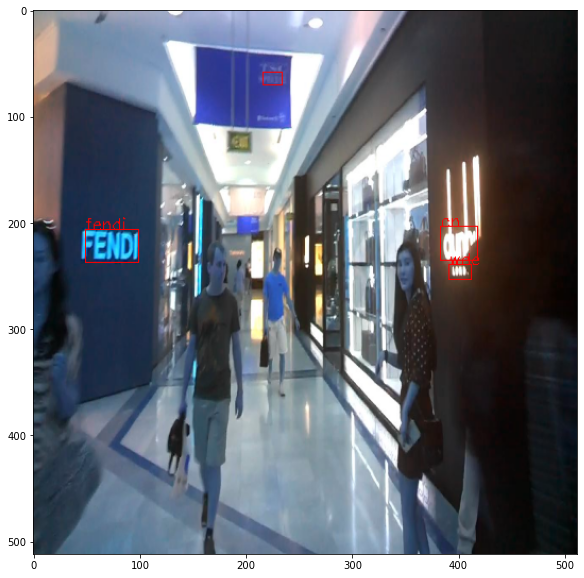

In [63]:
img=cv2.imread('data/ch4_test_images/img_1323.jpg',cv2.IMREAD_UNCHANGED)
#print(img.shape)
im=inferencePipeline_lite(img)
im=cv2.resize(im,dsize=(1200,720))
plt.figure(figsize=(10,10))
plt.imshow(im)

In [48]:
tf.__version__

'2.2.0'